In [35]:
import pandas as pd
import numpy as np
import pymongo
import warnings
import time
import random
from tqdm.notebook import tqdm
import itertools
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score, recall_score, precision_score
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

# CONEXIÓN

In [36]:
CONNECTION_STRING = "mongodb://proyectoestudiantes:suVKLoKoqjCxdeRnmZH7IICunDq54Ed33zaKcNzPBdxI2PVaohC0veT5diWHmsojaQCW6r2qohC9ACDbu5vPqQ==@proyectoestudiantes.mongo.cosmos.azure.com:10255/?ssl=true&replicaSet=globaldb&retrywrites=false&maxIdleTimeMS=120000&appName=@proyectoestudiantes@"

In [37]:
client = pymongo.MongoClient(CONNECTION_STRING)
db = client['Estudiantes']
collection = db['Estudiantes_Materias']

datos_raw = list(collection.find({}))

registros = []
for doc in datos_raw:
    datos_personales = doc.get('datos_personales', {})
    info_academica = doc.get('academico', {})
    location = doc.get('location', {})
    info_colegio = doc.get('colegio', {})
    puntajes = doc.get('ICFES', {})
    metricas = doc.get('metricas_rendimiento', {})
    estado = doc.get('estado', {})
    periodo_info = doc.get('periodo_info', {})
    
    # Manejar programa_secundario correctamente
    prog_sec = info_academica.get('programa_secundario')
    if prog_sec is None or prog_sec == '' or (isinstance(prog_sec, float) and np.isnan(prog_sec)):
        prog_sec = 'Ninguno'
    
    registro = {
        'edad': datos_personales.get('edad'),
        'genero': datos_personales.get('genero'),
        'estrato': datos_personales.get('estrato'),
        'discapacidad': datos_personales.get('discapacidad'),
        'programa': info_academica.get('programa'),
        'programa_secundario': prog_sec,
        'tiene_programa_secundario': 0 if prog_sec == 'Ninguno' else 1,
        'semestre_actual': info_academica.get('semestre_actual'),
        'tipo_estudiante': info_academica.get('tipo_estudiante'),
        'tipo_admision': info_academica.get('tipo_admision'),
        'estado_academico': info_academica.get('estado_academico'),
        'ciudad_residencia': location.get('ciudad'),
        'depto_residencia': location.get('departamento'),
        'pais': location.get('pais'),
        'es_barranquilla': location.get('es_barranquilla'),
        'es_colombia': location.get('es_colombia'),
        'tipo_colegio': info_colegio.get('tipo_colegio'),
        'calendario_colegio': info_colegio.get('calendario_colegio'),
        'descripcion_bachillerato': info_colegio.get('descripcion_bachillerato'),
        'puntaje_total': puntajes.get('puntaje_total'),
        'matematicas': puntajes.get('matematicas'),
        'lectura_critica': puntajes.get('lectura_critica'),
        'sociales': puntajes.get('sociales'),
        'ciencias': puntajes.get('ciencias'),
        'ingles': puntajes.get('ingles'),
        'promedio': metricas.get('promedio_acumulado'),
        'materias_cursadas': metricas.get('materias_cursadas_total'),
        'materias_perdidas': metricas.get('materias_perdidas_total'),
        'materias_repetidas': metricas.get('materias_repetidas'),
        'perdidas_por_depto': metricas.get('materias_perdidas_por_departamento', {}),
        'beca': estado.get('becado'),
        'graduado': estado.get('graduado'),
        'desertor': estado.get('desertor'),
        'ultimo_periodo': periodo_info.get('ultimo_periodo')
    }
    registros.append(registro)

df = pd.DataFrame(registros)
df = df[df['graduado'] == False]

print(f"Datos extraidos: {df.shape[0]} estudiantes x {df.shape[1]} variables")
print(f"Desertores: {df['desertor'].sum()} ({df['desertor'].sum()/len(df)*100:.2f}%)")

client.close()

Datos extraidos: 9455 estudiantes x 34 variables
Desertores: 586 (6.20%)


In [38]:
df

,edad,genero,estrato,discapacidad,programa,programa_secundario,tiene_programa_secundario,semestre_actual,tipo_estudiante,tipo_admision,...,ingles,promedio,materias_cursadas,materias_perdidas,materias_repetidas,perdidas_por_depto,beca,graduado,desertor,ultimo_periodo
0,17,F,5,00- Ninguno,Derecho,Ninguno,0,1.0,Estudiante regular,Ordinaria Pregrado,...,54.0,3.47,13,8,1,"{'Dpto. Derecho': 6, 'Dpto. de Economía': 1, '...",No becado,0,0,202510
1,18,M,1,00- Ninguno,Geología,Ninguno,0,1.0,Estudiante regular,Ordinaria Pregrado,...,56.0,3.82,11,5,1,"{'Dpto. Español': 1, 'Dpto. Historia y Cs. Soc...",No becado,0,1,202510
2,17,F,2,00- Ninguno,Odontología,Ninguno,0,1.0,Estudiante regular,Ordinaria Pregrado,...,100.0,4.03,9,6,0,"{'Dpto. Química y Biología': 2, 'Dpto. Español...",Institucional,0,0,202510
3,18,M,4,00- Ninguno,Ingeniería Industrial,Ninguno,0,1.0,Estudiante regular,Ordinaria Pregrado,...,78.0,4.18,10,5,0,"{'Dpto. Español': 1, 'Dpto. Ing. Civil y Ambie...",Institucional,0,0,202510
4,18,M,4,00- Ninguno,Economía,Ninguno,0,1.0,Estudiante regular,Ordinaria Pregrado,...,72.0,3.52,11,5,0,"{'Dpto. Español': 1, 'Dpto. de Economía': 2, '...",No becado,0,0,202510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10219,24,M,5,00- Ninguno,Diseño Gráfico,Ninguno,0,5.0,Estudiante regular,Ordinaria Pregrado,...,NaN,4.56,16,5,0,"{'Dpto. Historia y Cs. Sociales': 1, 'Dpto. Di...",No becado,0,0,202510
10221,24,F,4,00- Ninguno,Ingeniería Mecánica,Ninguno,0,7.0,Estudiante regular,Transferencia Externa,...,NaN,4.68,16,5,0,"{'Dpto.Ing Eléctrica-Electrónica': 1, 'Dpto. L...",No becado,0,0,202510
10222,22,M,4,00- Ninguno,Psicología,Ninguno,0,5.0,Estudiante regular,Ordinaria Pregrado,...,NaN,4.14,20,7,0,"{'Dpto. Humanidades y Filosofía': 1, 'Dpto. Le...",No becado,0,0,202510
10223,24,F,4,00- Ninguno,Medicina,Ninguno,0,11.0,Estudiante regular,Ordinaria Pregrado,...,NaN,4.18,9,4,0,"{'Dpto. Salud Pública': 1, 'Dpto. Medicina': 3}",No becado,0,0,202510


# Preprocesamiento

In [39]:
perdidas_df = pd.json_normalize(df['perdidas_por_depto'])
perdidas_df = perdidas_df.add_prefix('perdidas_')
df = pd.concat([df.drop('perdidas_por_depto', axis=1), perdidas_df], axis=1)

cols_perdidas_depto = [col for col in df.columns if col.startswith('perdidas_')]

df_desertores = df[df['desertor'] == 1].copy()
df_no_desertores = df[df['desertor'] == 0].copy()

numericas = df.select_dtypes(include=[np.number]).columns.tolist()
numericas = [col for col in numericas if col not in ['desertor', 'graduado']]

for col in numericas:
    if df[col].isna().sum() > 0:
        if col in cols_perdidas_depto or col == 'semestre_actual':
            # Llenar con 0: perdidas por departamento y semestre actual vacio
            df[col] = df[col].fillna(0)
        else:
            mediana_desertores = df_desertores[col].median()
            mediana_no_desertores = df_no_desertores[col].median()
            df.loc[(df['desertor'] == 1) & (df[col].isna()), col] = mediana_desertores
            df.loc[(df['desertor'] == 0) & (df[col].isna()), col] = mediana_no_desertores

categoricas = ['genero', 'discapacidad', 'programa', 'programa_secundario', 
               'tipo_estudiante', 'tipo_admision', 'estado_academico',
               'ciudad_residencia', 'depto_residencia', 'pais', 
               'tipo_colegio', 'calendario_colegio',
               'ultimo_periodo']

for col in categoricas:
    if col in df.columns and df[col].isna().sum() > 0:
        # Para programa_secundario, llenar con 'Ninguno' en lugar de moda
        if col == 'programa_secundario':
            df[col] = df[col].fillna('Ninguno')
        else:
            moda_desertores = df[df['desertor'] == 1][col].mode()
            moda_no_desertores = df[df['desertor'] == 0][col].mode()
            valor_desertores = moda_desertores[0] if len(moda_desertores) > 0 else 'Desconocido'
            valor_no_desertores = moda_no_desertores[0] if len(moda_no_desertores) > 0 else 'Desconocido'
            df.loc[(df['desertor'] == 1) & (df[col].isna()), col] = valor_desertores
            df.loc[(df['desertor'] == 0) & (df[col].isna()), col] = valor_no_desertores

encoders = {}
for col in categoricas:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        encoders[col] = le

cols_object = df.select_dtypes(include=['object']).columns.tolist()
cols_object = [col for col in cols_object if col not in ['desertor', 'graduado']]

if cols_object:
    for col in cols_object:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        encoders[col] = le

print(f"Datos procesados: {df.shape[0]} filas x {df.shape[1]} columnas")

Datos procesados: 10215 filas x 61 columnas


# partición

In [40]:
df = df.dropna(subset=['desertor'])

# Excluir descripcion_bachillerato del modelo
X = df.drop(['desertor', 'graduado', 'descripcion_bachillerato'], axis=1)
y = df['desertor'].astype(int)

# Primera división: 70% entrenamiento, 30% temporal
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Segunda división: dividir el 30% temporal en 15% validación y 15% prueba
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Escalar datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {X_train_scaled.shape[0]} ({X_train_scaled.shape[0]/len(df)*100:.1f}%)")
print(f"Validacion: {X_val_scaled.shape[0]} ({X_val_scaled.shape[0]/len(df)*100:.1f}%)")
print(f"Test: {X_test_scaled.shape[0]} ({X_test_scaled.shape[0]/len(df)*100:.1f}%)")
print(f"Features: {X_train_scaled.shape[1]}")
print(f"\nDistribucion desertores:")
print(f"Train: {y_train.sum()} ({y_train.sum()/len(y_train)*100:.1f}%)")
print(f"Validacion: {y_val.sum()} ({y_val.sum()/len(y_val)*100:.1f}%)")
print(f"Test: {y_test.sum()} ({y_test.sum()/len(y_test)*100:.1f}%)")

Train: 6618 (70.0%)
Validacion: 1418 (15.0%)
Test: 1419 (15.0%)
Features: 58

Distribucion desertores:
Train: 410 (6.2%)
Validacion: 88 (6.2%)
Test: 88 (6.2%)


# Configuración grid search 

In [41]:
# Diccionarios de configuracion para grid search EXPANDIDO
tecnicas_muestreo = {
    'smote_30': SMOTE(sampling_strategy=0.30, random_state=42),
    'smote_40': SMOTE(sampling_strategy=0.40, random_state=42),
    'smote_50': SMOTE(sampling_strategy=0.50, random_state=42),
    'smote_60': SMOTE(sampling_strategy=0.60, random_state=42)
}

class_weights_base = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
cw_base_dict = {0: class_weights_base[0], 1: class_weights_base[1]}

configuraciones_pesos = {
    'sin_pesos': None,
    'balanced': cw_base_dict,
    'high_recall_1.5x': {0: cw_base_dict[0], 1: cw_base_dict[1] * 1.5},
    'high_recall_2x': {0: cw_base_dict[0], 1: cw_base_dict[1] * 2},
    'high_recall_3x': {0: cw_base_dict[0], 1: cw_base_dict[1] * 3}
}

arquitecturas = {
   
    'light_3': [128, 64, 32],
    'medium_4': [512, 256, 128, 64],
    'deep_3': [512, 256, 256, 128, 64]
    
}

hiperparametros = {
    'dropout_rates': [0.2, 0.3, 0.4],
    'learning_rates': [ 0.001, 0.002],
    'batch_sizes': [64, 128, 256],
    'optimizers': ['adam', 'rmsprop']
}

regularizaciones = {
    'sin_regularizacion': None,
    'l2_very_light': l2(0.0001),
    'l2_light': l2(0.001)
    
}

thresholds = [0.3, 0.35, 0.4, 0.45, 0.5]



In [42]:
# Generar todas las combinaciones usando los diccionarios
random.seed(42)
np.random.seed(42)

configuraciones_entrenamiento = []

# Recorrer cada diccionario para generar combinaciones
for muestreo_nombre, muestreo_obj in tecnicas_muestreo.items():
    for peso_nombre, peso_obj in configuraciones_pesos.items():
        for arq_nombre, capas in arquitecturas.items():
            for dropout in hiperparametros['dropout_rates']:
                for lr in hiperparametros['learning_rates']:
                    for bs in hiperparametros['batch_sizes']:
                        for opt in hiperparametros['optimizers']:
                            for reg_nombre, reg_obj in regularizaciones.items():
                                config = {
                                    'muestreo_nombre': muestreo_nombre,
                                    'muestreo': muestreo_obj,
                                    'peso_nombre': peso_nombre,
                                    'pesos': peso_obj,
                                    'arquitectura_nombre': arq_nombre,
                                    'capas': capas,
                                    'dropout': dropout,
                                    'learning_rate': lr,
                                    'batch_size': bs,
                                    'optimizer': opt,
                                    'regularizacion_nombre': reg_nombre,
                                    'regularizacion': reg_obj,
                                }
                                configuraciones_entrenamiento.append(config)


# Muestreo aleatorio de configuraciones para hacer el proceso manejable
# Ajusta este número según tu capacidad de cómputo
MAX_CONFIGS = 100



print(f"Configuraciones generadas: {len(configuraciones_entrenamiento)}")
if len(configuraciones_entrenamiento) > MAX_CONFIGS:
    random.shuffle(configuraciones_entrenamiento)
    configuraciones_entrenamiento = configuraciones_entrenamiento[:MAX_CONFIGS]
print("solo  se entrenaran 100 modelos aleatorios de las configuraciones posibles")

Configuraciones generadas: 6480
solo  se entrenaran 100 modelos aleatorios de las configuraciones posibles


In [43]:
# Entrenar todos los modelos
resultados_busqueda = []
modelos_entrenados = {}

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=0)



# Barra de progreso
pbar = tqdm(enumerate(configuraciones_entrenamiento, 1), total=len(configuraciones_entrenamiento), 
            desc="Entrenando modelos", unit="modelo")

for idx, config in pbar:
    try:
        # Aplicar tecnica de muestreo
        if config['muestreo'] is not None:
            X_train_prep, y_train_prep = config['muestreo'].fit_resample(X_train_scaled, y_train)
        else:
            X_train_prep = X_train_scaled
            y_train_prep = y_train
        
        # Construir modelo
        modelo = Sequential()
        modelo.add(Dense(config['capas'][0], activation='relu', input_dim=X_train_prep.shape[1], 
                        kernel_regularizer=config['regularizacion']))
        modelo.add(Dropout(config['dropout']))
        
        for units in config['capas'][1:]:
            modelo.add(Dense(units, activation='relu', kernel_regularizer=config['regularizacion']))
            modelo.add(Dropout(config['dropout']))
        
        modelo.add(Dense(1, activation='sigmoid'))
        
        # Configurar optimizador
        if config['optimizer'] == 'adam':
            opt = Adam(learning_rate=config['learning_rate'])
        else:
            opt = RMSprop(learning_rate=config['learning_rate'])
        
        modelo.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
        
        # Entrenar
        inicio = time.time()
        history = modelo.fit(
            X_train_prep, y_train_prep, epochs=100, batch_size=config['batch_size'],
            validation_data=(X_val_scaled, y_val), class_weight=config['pesos'], 
            callbacks=[early_stop, reduce_lr], verbose=0
        )
        
        
        # Predecir en validación
        y_pred_proba = modelo.predict(X_val_scaled, verbose=0).flatten()
        
        # Guardar modelo
        modelo_id = f"modelo_{idx}"
        modelos_entrenados[modelo_id] = {
            'modelo': modelo,
            'config': config,
            'y_pred_proba': y_pred_proba,
            'history': history
        }
        
        # Evaluar con diferentes thresholds
        for thresh in thresholds:
            y_pred = (y_pred_proba >= thresh).astype(int)
            
            recall = recall_score(y_val, y_pred)
            precision = precision_score(y_val, y_pred, zero_division=0)
            f1 = f1_score(y_val, y_pred)
            auc = roc_auc_score(y_val, y_pred_proba)
            
            cm = confusion_matrix(y_val, y_pred)
            tn, fp, fn, tp = cm.ravel()
            
            score_custom = 0.6 * recall + 0.3 * auc + 0.1 * precision
            
            resultado = {
                'modelo_id': modelo_id, 'config_idx': idx,
                'muestreo': config['muestreo_nombre'], 'pesos': config['peso_nombre'],
                'arquitectura': config['arquitectura_nombre'], 'capas': str(config['capas']),
                'dropout': config['dropout'], 'learning_rate': config['learning_rate'],
                'batch_size': config['batch_size'], 'optimizer': config['optimizer'],
                'regularizacion': config['regularizacion_nombre'], 'threshold': thresh,
                'recall': recall, 'precision': precision, 'f1': f1, 'auc': auc,
                'score_custom': score_custom, 'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn,
                'epochs': len(history.history['loss'])
            }
            resultados_busqueda.append(resultado)
        
        # Actualizar barra de progreso
       
        
        
        
    except Exception as e:
        pbar.write(f"Error en modelo {idx}: {str(e)}")
        continue




Entrenando modelos:   0%|          | 0/100 [00:00<?, ?modelo/s]

# Nueva Estrategia: Recall ≥ 75% y Maximizar Precisión

Cambiaremos la función objetivo para priorizar:
- **Recall mínimo de 75%** (no perdemos más del 25% de desertores)
- **Maximizar Precisión** (reducir falsos positivos)
- **Mantener buen AUC** (capacidad discriminatoria)

Nueva función de score con penalización si recall < 75%:
```python
if recall < 0.75:
    score = recall * 0.5  # Penalizar fuertemente
else:
    score = 0.4 * precision + 0.35 * recall + 0.25 * auc
```

In [44]:
# Entrenar modelos con NUEVA función objetivo
resultados_busqueda_v2 = []
modelos_entrenados_v2 = {}

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=0)

# Barra de progreso
pbar = tqdm(enumerate(configuraciones_entrenamiento, 1), total=len(configuraciones_entrenamiento), 
            desc="Entrenando modelos v2", unit="modelo")

for idx, config in pbar:
    try:
        # Aplicar tecnica de muestreo
        if config['muestreo'] is not None:
            X_train_prep, y_train_prep = config['muestreo'].fit_resample(X_train_scaled, y_train)
        else:
            X_train_prep = X_train_scaled
            y_train_prep = y_train
        
        # Construir modelo
        modelo = Sequential()
        modelo.add(Dense(config['capas'][0], activation='relu', input_dim=X_train_prep.shape[1], 
                        kernel_regularizer=config['regularizacion']))
        modelo.add(Dropout(config['dropout']))
        
        for units in config['capas'][1:]:
            modelo.add(Dense(units, activation='relu', kernel_regularizer=config['regularizacion']))
            modelo.add(Dropout(config['dropout']))
        
        modelo.add(Dense(1, activation='sigmoid'))
        
        # Configurar optimizador
        if config['optimizer'] == 'adam':
            opt = Adam(learning_rate=config['learning_rate'])
        else:
            opt = RMSprop(learning_rate=config['learning_rate'])
        
        modelo.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
        
        # Entrenar
        history = modelo.fit(
            X_train_prep, y_train_prep, epochs=100, batch_size=config['batch_size'],
            validation_data=(X_val_scaled, y_val), class_weight=config['pesos'], 
            callbacks=[early_stop, reduce_lr], verbose=0
        )
        
        # Predecir en validación
        y_pred_proba = modelo.predict(X_val_scaled, verbose=0).flatten()
        
        # Guardar modelo
        modelo_id = f"modelo_v2_{idx}"
        modelos_entrenados_v2[modelo_id] = {
            'modelo': modelo,
            'config': config,
            'y_pred_proba': y_pred_proba,
            'history': history
        }
        
        # Evaluar con diferentes thresholds (incluyendo valores más bajos para aumentar recall)
        thresholds_extended = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
        
        for thresh in thresholds_extended:
            y_pred = (y_pred_proba >= thresh).astype(int)
            
            recall = recall_score(y_val, y_pred)
            precision = precision_score(y_val, y_pred, zero_division=0)
            f1 = f1_score(y_val, y_pred)
            auc = roc_auc_score(y_val, y_pred_proba)
            
            cm = confusion_matrix(y_val, y_pred)
            tn, fp, fn, tp = cm.ravel()
            
            # NUEVA FUNCIÓN OBJETIVO: Priorizar recall ≥ 75% y maximizar precisión
            if recall < 0.75:
                score_custom = recall * 0.5  # Penalizar fuertemente si recall < 75%
            else:
                # Si recall ≥ 75%, optimizar por precisión, luego recall, luego AUC
                score_custom = 0.4 * precision + 0.35 * recall + 0.25 * auc
            
            resultado = {
                'modelo_id': modelo_id, 'config_idx': idx,
                'muestreo': config['muestreo_nombre'], 'pesos': config['peso_nombre'],
                'arquitectura': config['arquitectura_nombre'], 'capas': str(config['capas']),
                'dropout': config['dropout'], 'learning_rate': config['learning_rate'],
                'batch_size': config['batch_size'], 'optimizer': config['optimizer'],
                'regularizacion': config['regularizacion_nombre'], 'threshold': thresh,
                'recall': recall, 'precision': precision, 'f1': f1, 'auc': auc,
                'score_custom': score_custom, 'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn,
                'epochs': len(history.history['loss'])
            }
            resultados_busqueda_v2.append(resultado)
        
    except Exception as e:
        pbar.write(f"Error en modelo {idx}: {str(e)}")
        continue

print(f"\n✓ Entrenamiento completado: {len(modelos_entrenados_v2)} modelos")

Entrenando modelos v2:   0%|          | 0/100 [00:00<?, ?modelo/s]


✓ Entrenamiento completado: 100 modelos


In [45]:
# Análisis de resultados V2
df_resultados_v2 = pd.DataFrame(resultados_busqueda_v2)

print(f"Total de resultados v2: {len(df_resultados_v2)}")
print(f"Modelos entrenados v2: {len(modelos_entrenados_v2)}")

# Filtrar SOLO modelos con recall >= 75%
df_recall_75 = df_resultados_v2[df_resultados_v2['recall'] >= 0.75].copy()

print(f"\n{'='*80}")
print(f"MODELOS CON RECALL ≥ 75%: {len(df_recall_75)} configuraciones")
print(f"{'='*80}")

if len(df_recall_75) > 0:
    # Ordenar por precisión (queremos maximizar precisión entre los que tienen recall ≥ 75%)
    top_10_precision = df_recall_75.nlargest(10, 'precision')[
        ['modelo_id', 'muestreo', 'arquitectura', 'dropout', 'threshold', 
         'recall', 'precision', 'f1', 'auc', 'score_custom']
    ]
    
    print("\n🎯 TOP 10 MODELOS CON RECALL ≥ 75% (Ordenados por Precisión):")
    display(top_10_precision)
    
    # También ver distribución de recall
    print(f"\n📊 ESTADÍSTICAS DE RECALL (modelos con recall ≥ 75%):")
    print(f"  - Recall mínimo: {df_recall_75['recall'].min():.4f}")
    print(f"  - Recall promedio: {df_recall_75['recall'].mean():.4f}")
    print(f"  - Recall máximo: {df_recall_75['recall'].max():.4f}")
    
    print(f"\n📊 ESTADÍSTICAS DE PRECISIÓN (modelos con recall ≥ 75%):")
    print(f"  - Precisión mínima: {df_recall_75['precision'].min():.4f}")
    print(f"  - Precisión promedio: {df_recall_75['precision'].mean():.4f}")
    print(f"  - Precisión máxima: {df_recall_75['precision'].max():.4f}")
else:
    print("\n⚠️ NO SE ENCONTRARON MODELOS CON RECALL ≥ 75%")
    print("Mostrando los 10 mejores por recall:")
    top_10_by_recall = df_resultados_v2.nlargest(10, 'recall')[
        ['modelo_id', 'muestreo', 'arquitectura', 'threshold', 
         'recall', 'precision', 'f1', 'auc']
    ]
    display(top_10_by_recall)

Total de resultados v2: 900
Modelos entrenados v2: 100

MODELOS CON RECALL ≥ 75%: 735 configuraciones

🎯 TOP 10 MODELOS CON RECALL ≥ 75% (Ordenados por Precisión):


,modelo_id,muestreo,arquitectura,dropout,threshold,recall,precision,f1,auc,score_custom
741,modelo_v2_83,smote_30,medium_4,0.2,0.35,0.761364,0.170051,0.278008,0.809159,0.536787
423,modelo_v2_48,smote_40,deep_3,0.2,0.20,0.750000,0.168367,0.275000,0.814252,0.533410
740,modelo_v2_83,smote_30,medium_4,0.2,0.30,0.772727,0.158508,0.263056,0.809159,0.536148
419,modelo_v2_47,smote_60,deep_3,0.3,0.45,0.750000,0.155294,0.257310,0.790542,0.522253
389,modelo_v2_44,smote_60,medium_4,0.4,0.30,0.761364,0.148230,0.248148,0.801119,0.526049
739,modelo_v2_83,smote_30,medium_4,0.2,0.25,0.806818,0.146998,0.248687,0.809159,0.543475
418,modelo_v2_47,smote_60,deep_3,0.3,0.40,0.772727,0.146552,0.246377,0.790542,0.526711
862,modelo_v2_96,smote_30,deep_3,0.4,0.55,0.806818,0.142285,0.241908,0.802589,0.539947
838,modelo_v2_94,smote_50,deep_3,0.4,0.25,0.750000,0.141935,0.238698,0.783518,0.515154
605,modelo_v2_68,smote_60,light_3,0.2,0.30,0.761364,0.139875,0.236332,0.805895,0.523901



📊 ESTADÍSTICAS DE RECALL (modelos con recall ≥ 75%):
  - Recall mínimo: 0.7500
  - Recall promedio: 0.9564
  - Recall máximo: 1.0000

📊 ESTADÍSTICAS DE PRECISIÓN (modelos con recall ≥ 75%):
  - Precisión mínima: 0.0616
  - Precisión promedio: 0.0740
  - Precisión máxima: 0.1701


# Análisis de Resultados

In [46]:
# Convertir resultados a DataFrame
df_resultados = pd.DataFrame(resultados_busqueda)

print(f"Total de resultados: {len(df_resultados)}")
print(f"Modelos entrenados: {len(modelos_entrenados)}")
print(f"Configuraciones por modelo: {len(df_resultados) // len(modelos_entrenados)} thresholds")

# Ver primeras filas
df_resultados.head(10)

Total de resultados: 500
Modelos entrenados: 100
Configuraciones por modelo: 5 thresholds


,modelo_id,config_idx,muestreo,pesos,arquitectura,capas,dropout,learning_rate,batch_size,optimizer,...,recall,precision,f1,auc,score_custom,tp,fp,tn,fn,epochs
0,modelo_1,1,smote_60,balanced,medium_4,"[512, 256, 128, 64]",0.4,0.002,128,adam,...,0.329545,0.295918,0.311828,0.778554,0.460885,29,69,1261,59,58
1,modelo_1,1,smote_60,balanced,medium_4,"[512, 256, 128, 64]",0.4,0.002,128,adam,...,0.329545,0.308511,0.318681,0.778554,0.462145,29,65,1265,59,58
2,modelo_1,1,smote_60,balanced,medium_4,"[512, 256, 128, 64]",0.4,0.002,128,adam,...,0.329545,0.318681,0.324022,0.778554,0.463162,29,62,1268,59,58
3,modelo_1,1,smote_60,balanced,medium_4,"[512, 256, 128, 64]",0.4,0.002,128,adam,...,0.329545,0.325843,0.327684,0.778554,0.463878,29,60,1270,59,58
4,modelo_1,1,smote_60,balanced,medium_4,"[512, 256, 128, 64]",0.4,0.002,128,adam,...,0.329545,0.325843,0.327684,0.778554,0.463878,29,60,1270,59,58
5,modelo_2,2,smote_50,high_recall_3x,medium_4,"[512, 256, 128, 64]",0.2,0.002,128,adam,...,1.000000,0.062059,0.116866,0.782937,0.841087,88,1330,0,0,10
6,modelo_2,2,smote_50,high_recall_3x,medium_4,"[512, 256, 128, 64]",0.2,0.002,128,adam,...,1.000000,0.062235,0.117177,0.782937,0.841105,88,1326,4,0,10
7,modelo_2,2,smote_50,high_recall_3x,medium_4,"[512, 256, 128, 64]",0.2,0.002,128,adam,...,0.988636,0.062232,0.117093,0.782937,0.834286,87,1311,19,1,10
8,modelo_2,2,smote_50,high_recall_3x,medium_4,"[512, 256, 128, 64]",0.2,0.002,128,adam,...,0.965909,0.064639,0.121169,0.782937,0.820891,85,1230,100,3,10
9,modelo_2,2,smote_50,high_recall_3x,medium_4,"[512, 256, 128, 64]",0.2,0.002,128,adam,...,0.954545,0.073749,0.136919,0.782937,0.814983,84,1055,275,4,10


In [47]:
# Top 10 modelos por score_custom (prioriza recall)
top_10_custom = df_resultados.nlargest(10, 'score_custom')[
    ['modelo_id', 'muestreo', 'arquitectura', 'dropout', 'learning_rate', 
     'batch_size', 'optimizer', 'threshold', 'recall', 'precision', 'f1', 'auc', 'score_custom']
]

print("TOP 10 MODELOS POR SCORE CUSTOM (60% Recall + 30% AUC + 10% Precision)")
display(top_10_custom)

TOP 10 MODELOS POR SCORE CUSTOM (60% Recall + 30% AUC + 10% Precision)


,modelo_id,muestreo,arquitectura,dropout,learning_rate,batch_size,optimizer,threshold,recall,precision,f1,auc,score_custom
185,modelo_38,smote_60,medium_4,0.2,0.001,256,adam,0.30,1.0,0.062059,0.116866,0.824154,0.853452
186,modelo_38,smote_60,medium_4,0.2,0.001,256,adam,0.35,1.0,0.062059,0.116866,0.824154,0.853452
187,modelo_38,smote_60,medium_4,0.2,0.001,256,adam,0.40,1.0,0.062059,0.116866,0.824154,0.853452
188,modelo_38,smote_60,medium_4,0.2,0.001,256,adam,0.45,1.0,0.062059,0.116866,0.824154,0.853452
189,modelo_38,smote_60,medium_4,0.2,0.001,256,adam,0.50,1.0,0.062059,0.116866,0.824154,0.853452
424,modelo_85,smote_60,deep_3,0.4,0.001,256,rmsprop,0.50,1.0,0.062544,0.117726,0.823872,0.853416
420,modelo_85,smote_60,deep_3,0.4,0.001,256,rmsprop,0.30,1.0,0.062059,0.116866,0.823872,0.853368
421,modelo_85,smote_60,deep_3,0.4,0.001,256,rmsprop,0.35,1.0,0.062059,0.116866,0.823872,0.853368
422,modelo_85,smote_60,deep_3,0.4,0.001,256,rmsprop,0.40,1.0,0.062059,0.116866,0.823872,0.853368
423,modelo_85,smote_60,deep_3,0.4,0.001,256,rmsprop,0.45,1.0,0.062059,0.116866,0.823872,0.853368


In [48]:
# Análisis por arquitectura y muestreo SMOTE
print("\nDESEMPEÑO PROMEDIO POR ARQUITECTURA")
desempeno_arquitectura = df_resultados.groupby('arquitectura').agg({
    'recall': ['mean', 'std', 'max'],
    'precision': ['mean', 'std', 'max'],
    'f1': ['mean', 'std', 'max'],
    'auc': ['mean', 'std', 'max'],
    'score_custom': ['mean', 'std', 'max']
}).round(4)
display(desempeno_arquitectura)

print("\nDESEMPEÑO PROMEDIO POR ESTRATEGIA DE MUESTREO (SMOTE)")
desempeno_muestreo = df_resultados.groupby('muestreo').agg({
    'recall': ['mean', 'std', 'max'],
    'precision': ['mean', 'std', 'max'],
    'f1': ['mean', 'std', 'max'],
    'auc': ['mean', 'std', 'max'],
    'score_custom': ['mean', 'std', 'max']
}).round(4)
display(desempeno_muestreo)


DESEMPEÑO PROMEDIO POR ARQUITECTURA


recall              precision                      f1          \
                mean     std  max      mean     std     max    mean     std   
arquitectura                                                                  
deep_3        0.8665  0.1709  1.0    0.1044  0.0660  0.3214  0.1714  0.0744   
light_3       0.8431  0.2630  1.0    0.1125  0.0913  0.5000  0.1616  0.0772   
medium_4      0.8833  0.1822  1.0    0.1002  0.0694  0.3455  0.1624  0.0704   

                         auc                 score_custom                  
                 max    mean     std     max         mean     std     max  
arquitectura                                                               
deep_3        0.3553  0.7930  0.0204  0.8239       0.7682  0.0976  0.8534  
light_3       0.3525  0.7881  0.0271  0.8200       0.7535  0.1545  0.8524  
medium_4      0.3838  0.7923  0.0162  0.8242       0.7777  0.1048  0.8535


DESEMPEÑO PROMEDIO POR ESTRATEGIA DE MUESTREO (SMOTE)


recall              precision                      f1          \
            mean     std  max      mean     std     max    mean     std   
muestreo                                                                  
smote_30  0.7431  0.2801  1.0    0.1533  0.1069  0.5000  0.2038  0.0959   
smote_40  0.9200  0.1392  1.0    0.0845  0.0459  0.2806  0.1474  0.0554   
smote_50  0.9039  0.1395  1.0    0.0893  0.0478  0.2778  0.1548  0.0583   
smote_60  0.9014  0.1711  1.0    0.0923  0.0597  0.3258  0.1542  0.0633   

                     auc                 score_custom                  
             max    mean     std     max         mean     std     max  
muestreo                                                               
smote_30  0.3838  0.7885  0.0266  0.8151       0.6977  0.1623  0.8513  
smote_40  0.3502  0.7945  0.0184  0.8200       0.7988  0.0815  0.8524  
smote_50  0.3596  0.7880  0.0167  0.8143       0.7877  0.0810  0.8505  
smote_60  0.3277  0.7943  0.0201  0.8242       0.7883  0.1002  0.8535

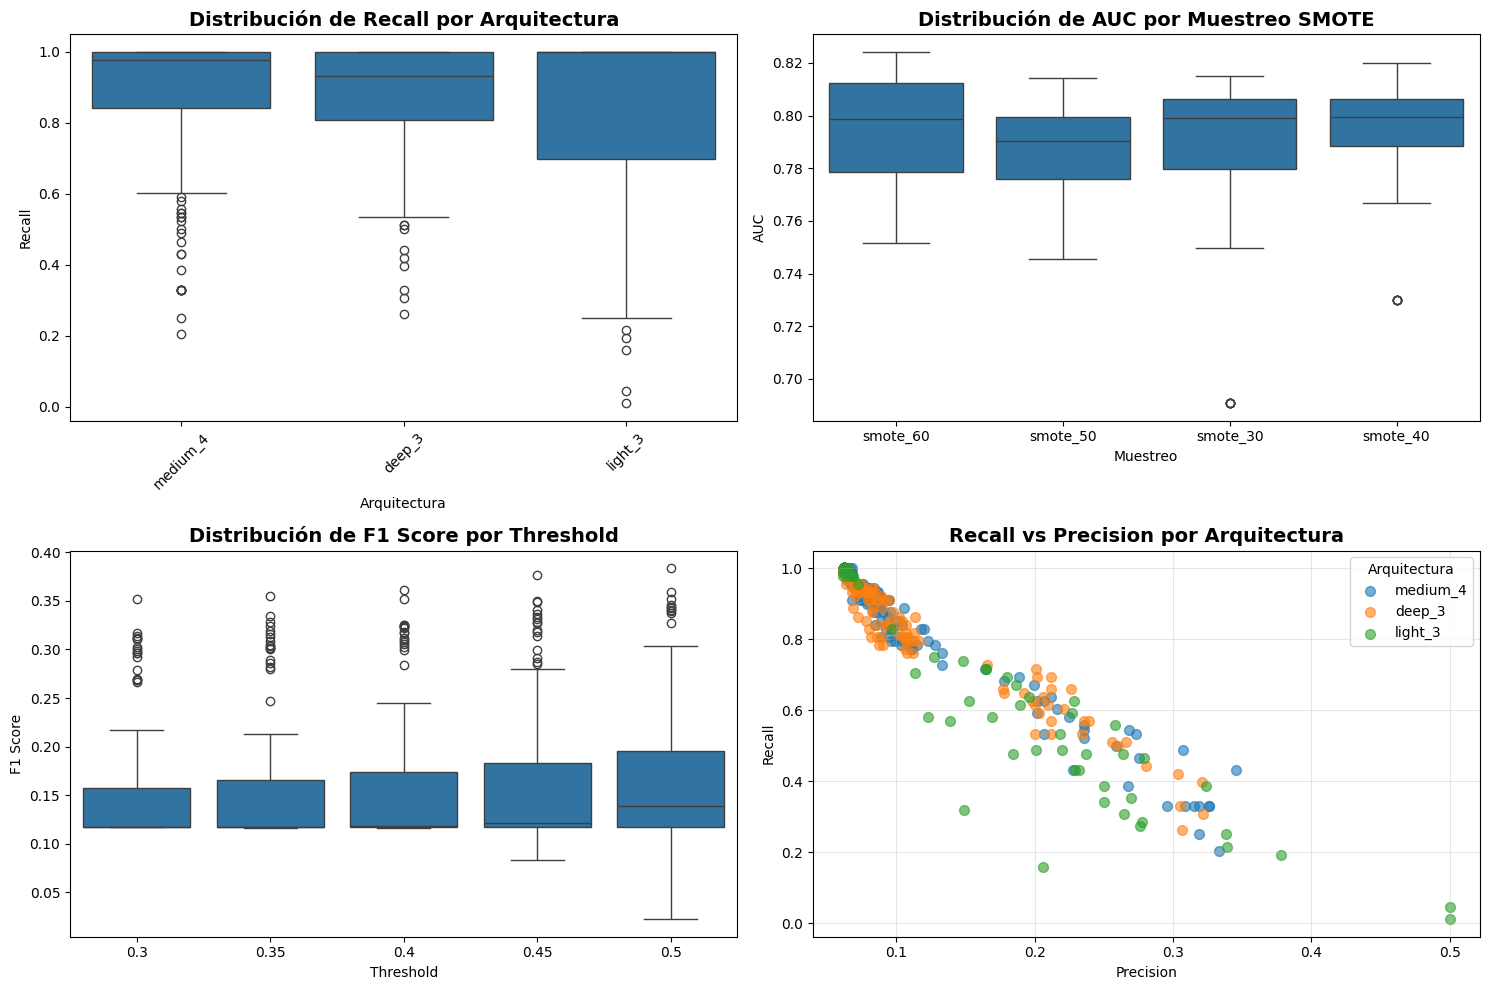

In [49]:
# Visualización: Distribución de métricas
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Recall por arquitectura
sns.boxplot(data=df_resultados, x='arquitectura', y='recall', ax=axes[0, 0])
axes[0, 0].set_title('Distribución de Recall por Arquitectura', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Arquitectura')
axes[0, 0].set_ylabel('Recall')
axes[0, 0].tick_params(axis='x', rotation=45)

# AUC por muestreo
sns.boxplot(data=df_resultados, x='muestreo', y='auc', ax=axes[0, 1])
axes[0, 1].set_title('Distribución de AUC por Muestreo SMOTE', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Muestreo')
axes[0, 1].set_ylabel('AUC')

# F1 Score por threshold
sns.boxplot(data=df_resultados, x='threshold', y='f1', ax=axes[1, 0])
axes[1, 0].set_title('Distribución de F1 Score por Threshold', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Threshold')
axes[1, 0].set_ylabel('F1 Score')

# Recall vs Precision scatter
for arquitectura in df_resultados['arquitectura'].unique():
    datos = df_resultados[df_resultados['arquitectura'] == arquitectura]
    axes[1, 1].scatter(datos['precision'], datos['recall'], label=arquitectura, alpha=0.6, s=50)
axes[1, 1].set_title('Recall vs Precision por Arquitectura', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Precision')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend(title='Arquitectura')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [50]:
# Mejor modelo global
mejor_idx = df_resultados['score_custom'].idxmax()
mejor_modelo = df_resultados.loc[mejor_idx]

print("\nMEJOR MODELO GLOBAL (SCORE CUSTOM MÁS ALTO)")
print(f"\nID del Modelo: {mejor_modelo['modelo_id']}")
print(f"Configuración: {mejor_modelo['config_idx']}")
print("\n--- HIPERPARÁMETROS ---")
print(f"Muestreo SMOTE: {mejor_modelo['muestreo']}")
print(f"Arquitectura: {mejor_modelo['arquitectura']}")
print(f"Capas: {mejor_modelo['capas']}")
print(f"Dropout: {mejor_modelo['dropout']}")
print(f"Learning Rate: {mejor_modelo['learning_rate']}")
print(f"Batch Size: {mejor_modelo['batch_size']}")
print(f"Optimizer: {mejor_modelo['optimizer']}")
print(f"Regularización: {mejor_modelo['regularizacion']}")
print(f"Threshold: {mejor_modelo['threshold']}")
print(f"Epochs: {mejor_modelo['epochs']}")

print("\n--- MÉTRICAS DE DESEMPEÑO ---")
print(f"Recall: {mejor_modelo['recall']:.4f}")
print(f"Precision: {mejor_modelo['precision']:.4f}")
print(f"F1 Score: {mejor_modelo['f1']:.4f}")
print(f"AUC: {mejor_modelo['auc']:.4f}")
print(f"Score Custom: {mejor_modelo['score_custom']:.4f}")

print("\n--- MATRIZ DE CONFUSIÓN ---")
print(f"True Positives (TP): {int(mejor_modelo['tp'])}")
print(f"False Positives (FP): {int(mejor_modelo['fp'])}")
print(f"True Negatives (TN): {int(mejor_modelo['tn'])}")
print(f"False Negatives (FN): {int(mejor_modelo['fn'])}")
print("=" * 100)


MEJOR MODELO GLOBAL (SCORE CUSTOM MÁS ALTO)

ID del Modelo: modelo_38
Configuración: 38

--- HIPERPARÁMETROS ---
Muestreo SMOTE: smote_60
Arquitectura: medium_4
Capas: [512, 256, 128, 64]
Dropout: 0.2
Learning Rate: 0.001
Batch Size: 256
Optimizer: adam
Regularización: sin_regularizacion
Threshold: 0.3
Epochs: 10

--- MÉTRICAS DE DESEMPEÑO ---
Recall: 1.0000
Precision: 0.0621
F1 Score: 0.1169
AUC: 0.8242
Score Custom: 0.8535

--- MATRIZ DE CONFUSIÓN ---
True Positives (TP): 88
False Positives (FP): 1330
True Negatives (TN): 0
False Negatives (FN): 0


In [51]:
# Análisis de threshold óptimo por modelo base
print("\nMEJOR THRESHOLD POR CADA MODELO BASE (sin considerar threshold)")

# Agrupar por modelo_id y encontrar el mejor threshold para cada uno
mejores_por_modelo = df_resultados.loc[df_resultados.groupby('modelo_id')['score_custom'].idxmax()]
mejores_por_modelo_sorted = mejores_por_modelo.sort_values('score_custom', ascending=False).head(10)

display(mejores_por_modelo_sorted[[
    'modelo_id', 'muestreo', 'arquitectura', 'dropout', 'learning_rate', 
    'optimizer', 'threshold', 'recall', 'precision', 'f1', 'auc', 'score_custom'
]])


MEJOR THRESHOLD POR CADA MODELO BASE (sin considerar threshold)


,modelo_id,muestreo,arquitectura,dropout,learning_rate,optimizer,threshold,recall,precision,f1,auc,score_custom
185,modelo_38,smote_60,medium_4,0.2,0.001,adam,0.3,1.0,0.062059,0.116866,0.824154,0.853452
424,modelo_85,smote_60,deep_3,0.4,0.001,rmsprop,0.5,1.0,0.062544,0.117726,0.823872,0.853416
159,modelo_32,smote_40,light_3,0.3,0.002,adam,0.5,1.0,0.064234,0.120713,0.820036,0.852434
430,modelo_87,smote_60,deep_3,0.3,0.001,adam,0.3,1.0,0.062059,0.116866,0.820711,0.852419
365,modelo_74,smote_60,deep_3,0.4,0.001,rmsprop,0.3,1.0,0.062059,0.116866,0.817550,0.851471
84,modelo_17,smote_30,medium_4,0.4,0.002,adam,0.5,1.0,0.067954,0.127260,0.815114,0.851330
265,modelo_54,smote_40,medium_4,0.4,0.002,adam,0.3,1.0,0.062059,0.116866,0.815320,0.850802
340,modelo_69,smote_50,deep_3,0.2,0.001,adam,0.3,1.0,0.062059,0.116866,0.814328,0.850504
314,modelo_63,smote_60,light_3,0.4,0.002,adam,0.5,1.0,0.062103,0.116944,0.814021,0.850417
360,modelo_73,smote_60,light_3,0.3,0.001,adam,0.3,1.0,0.062059,0.116866,0.813047,0.850120


In [52]:
# Guardar el mejor modelo
mejor_modelo_id = mejor_modelo['modelo_id']
mejor_modelo_obj = modelos_entrenados[mejor_modelo_id]['modelo']

# Guardar el modelo completo
mejor_modelo_obj.save('mejor_modelo_desercion.keras')
print(f"Modelo guardado como: mejor_modelo_desercion.keras")

# Guardar también información de la configuración y métricas
import json

info_modelo = {
    'modelo_id': mejor_modelo_id,
    'config_idx': int(mejor_modelo['config_idx']),
    'hiperparametros': {
        'muestreo': mejor_modelo['muestreo'],
        'pesos': mejor_modelo['pesos'],
        'arquitectura': mejor_modelo['arquitectura'],
        'capas': mejor_modelo['capas'],
        'dropout': float(mejor_modelo['dropout']),
        'learning_rate': float(mejor_modelo['learning_rate']),
        'batch_size': int(mejor_modelo['batch_size']),
        'optimizer': mejor_modelo['optimizer'],
        'regularizacion': mejor_modelo['regularizacion'],
        'threshold': float(mejor_modelo['threshold']),
        'epochs': int(mejor_modelo['epochs'])
    },
    'metricas': {
        'recall': float(mejor_modelo['recall']),
        'precision': float(mejor_modelo['precision']),
        'f1': float(mejor_modelo['f1']),
        'auc': float(mejor_modelo['auc']),
        'score_custom': float(mejor_modelo['score_custom'])
    },
    'matriz_confusion': {
        'tp': int(mejor_modelo['tp']),
        'fp': int(mejor_modelo['fp']),
        'tn': int(mejor_modelo['tn']),
        'fn': int(mejor_modelo['fn'])
    }
}

with open('mejor_modelo_info.json', 'w', encoding='utf-8') as f:
    json.dump(info_modelo, f, indent=4, ensure_ascii=False)



Modelo guardado como: mejor_modelo_desercion.keras


# Modelos Alternativos: Árbol de Decisión y Regresión Logística

In [53]:
# Importar modelos adicionales
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import pickle



## 1. Árbol de Decisión

In [54]:


# Crear y entrenar el modelo
dt_model = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',
    random_state=42
)

dt_model.fit(X_train_scaled, y_train)

# Predecir en validación
y_pred_dt_val = dt_model.predict(X_val_scaled)
y_pred_proba_dt_val = dt_model.predict_proba(X_val_scaled)[:, 1]

# Métricas en validación
recall_dt = recall_score(y_val, y_pred_dt_val)
precision_dt = precision_score(y_val, y_pred_dt_val)
f1_dt = f1_score(y_val, y_pred_dt_val)
auc_dt = roc_auc_score(y_val, y_pred_proba_dt_val)

cm_dt = confusion_matrix(y_val, y_pred_dt_val)
tn_dt, fp_dt, fn_dt, tp_dt = cm_dt.ravel()

print("\n--- ÁRBOL DE DECISIÓN - VALIDACIÓN ---")
print(f"Recall: {recall_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"F1 Score: {f1_dt:.4f}")
print(f"AUC: {auc_dt:.4f}")
print(f"\nMatriz de Confusión:")
print(f"TP: {tp_dt}, FP: {fp_dt}")
print(f"FN: {fn_dt}, TN: {tn_dt}")

# Guardar modelo
with open('modelo_arbol_decision.pkl', 'wb') as f:
    pickle.dump(dt_model, f)
print("\nModelo guardado como: modelo_arbol_decision.pkl")


--- ÁRBOL DE DECISIÓN - VALIDACIÓN ---
Recall: 0.6023
Precision: 0.1840
F1 Score: 0.2819
AUC: 0.6735

Matriz de Confusión:
TP: 53, FP: 235
FN: 35, TN: 1095

Modelo guardado como: modelo_arbol_decision.pkl

Modelo guardado como: modelo_arbol_decision.pkl


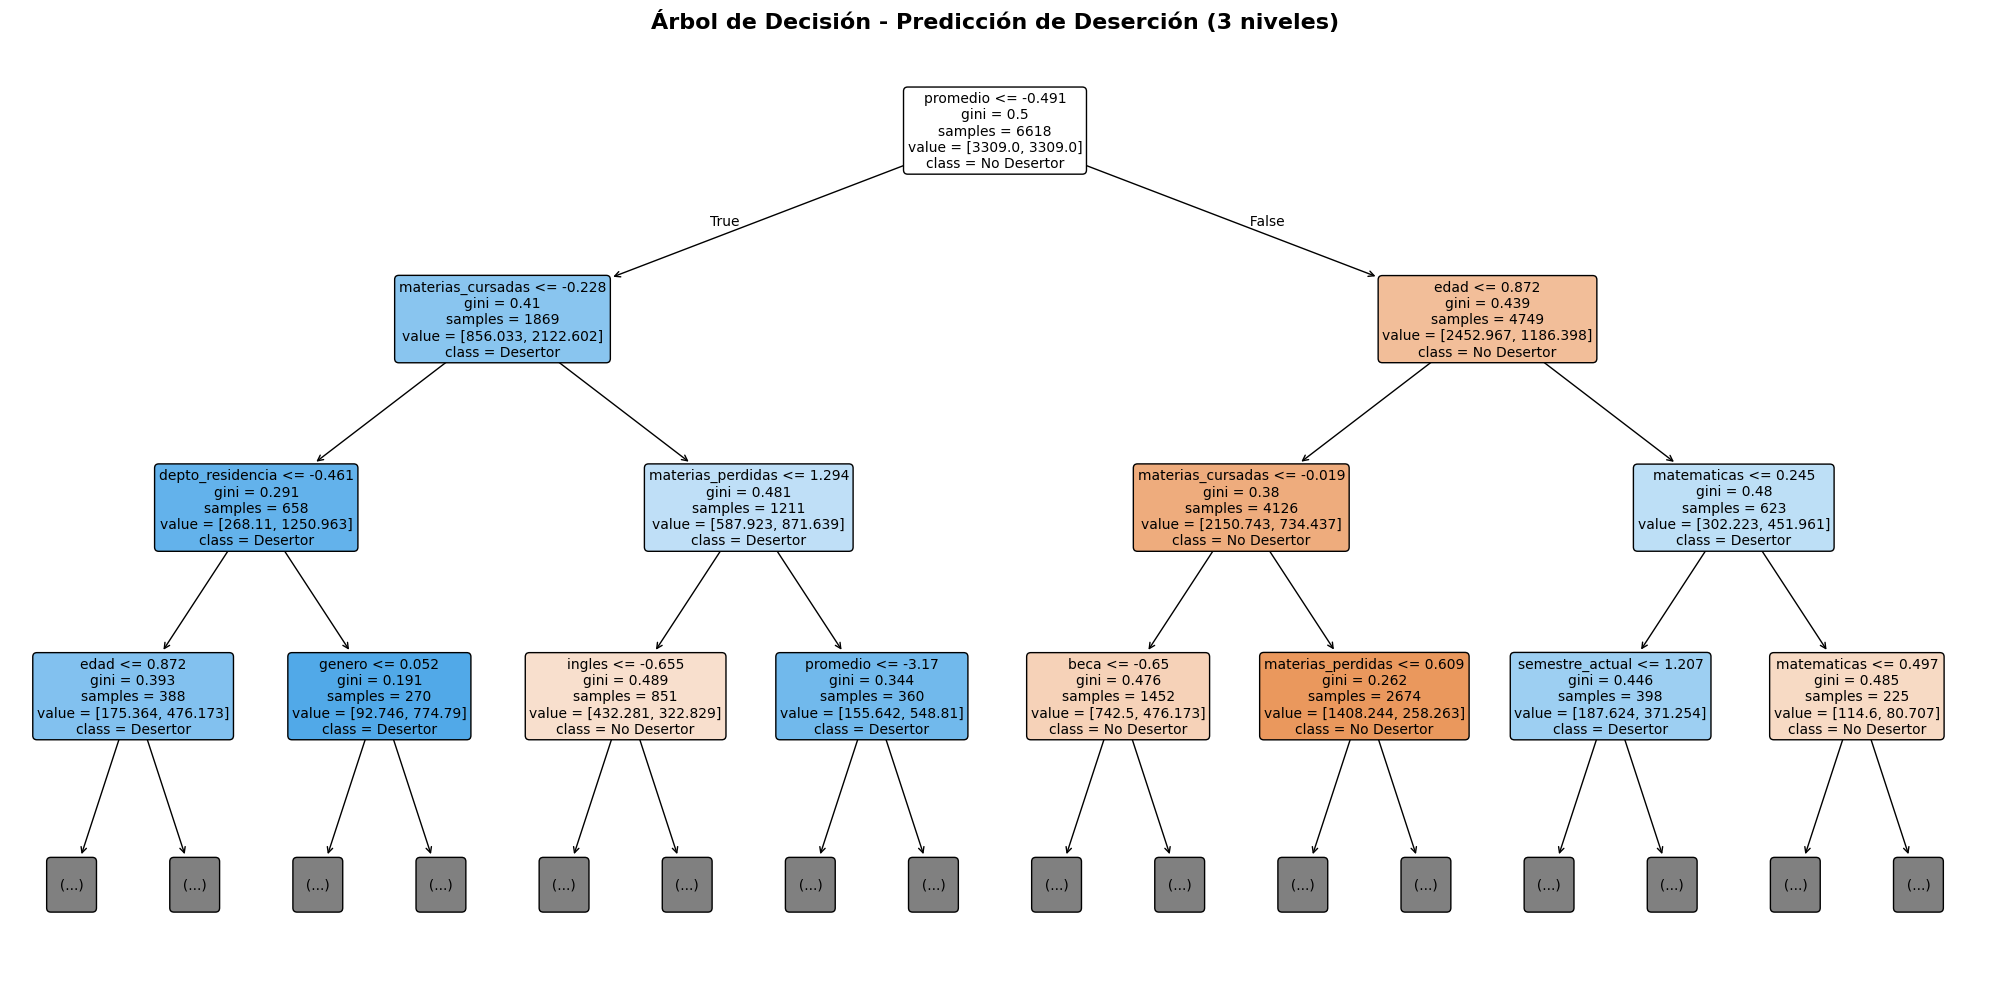


REGLAS DEL ÁRBOL DE DECISIÓN (3 primeros niveles):
|--- promedio <= -0.49
|   |--- materias_cursadas <= -0.23
|   |   |--- depto_residencia <= -0.46
|   |   |   |--- edad <= 0.87
|   |   |   |   |--- truncated branch of depth 7
|   |   |   |--- edad >  0.87
|   |   |   |   |--- truncated branch of depth 7
|   |   |--- depto_residencia >  -0.46
|   |   |   |--- genero <= 0.05
|   |   |   |   |--- truncated branch of depth 5
|   |   |   |--- genero >  0.05
|   |   |   |   |--- truncated branch of depth 7
|   |--- materias_cursadas >  -0.23
|   |   |--- materias_perdidas <= 1.29
|   |   |   |--- ingles <= -0.65
|   |   |   |   |--- truncated branch of depth 7
|   |   |   |--- ingles >  -0.65
|   |   |   |   |--- truncated branch of depth 6
|   |   |--- materias_perdidas >  1.29
|   |   |   |--- promedio <= -3.17
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- promedio >  -3.17
|   |   |   |   |--- truncated branch of depth 7
|--- promedio >  -0.49
|   |--- edad <= 0.87


In [55]:
# Visualizar el Árbol de Decisión
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(dt_model, 
          max_depth=3,  # Mostrar solo 3 niveles para mayor legibilidad
          feature_names=X.columns,
          class_names=['No Desertor', 'Desertor'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Árbol de Decisión - Predicción de Deserción (3 niveles)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# También generar reporte de texto con las reglas del árbol
from sklearn.tree import export_text

tree_rules = export_text(dt_model, feature_names=list(X.columns), max_depth=3)
print("\nREGLAS DEL ÁRBOL DE DECISIÓN (3 primeros niveles):")
print(tree_rules)


IMPORTANCIA DE VARIABLES - ÁRBOL DE DECISIÓN
Top 20 variables más importantes:
                              Feature  Importance
                             promedio    0.254631
                    materias_cursadas    0.092831
                                 edad    0.075998
                    materias_perdidas    0.072631
                              estrato    0.053459
                             programa    0.052341
                      semestre_actual    0.042455
                               ingles    0.041622
                     depto_residencia    0.037180
                   materias_repetidas    0.035360
                          matematicas    0.031881
                               genero    0.025996
                                 beca    0.025281
                      lectura_critica    0.022968
                    ciudad_residencia    0.014083
                             sociales    0.013532
                             ciencias    0.013458
perdidas_Dpto. Ing. 

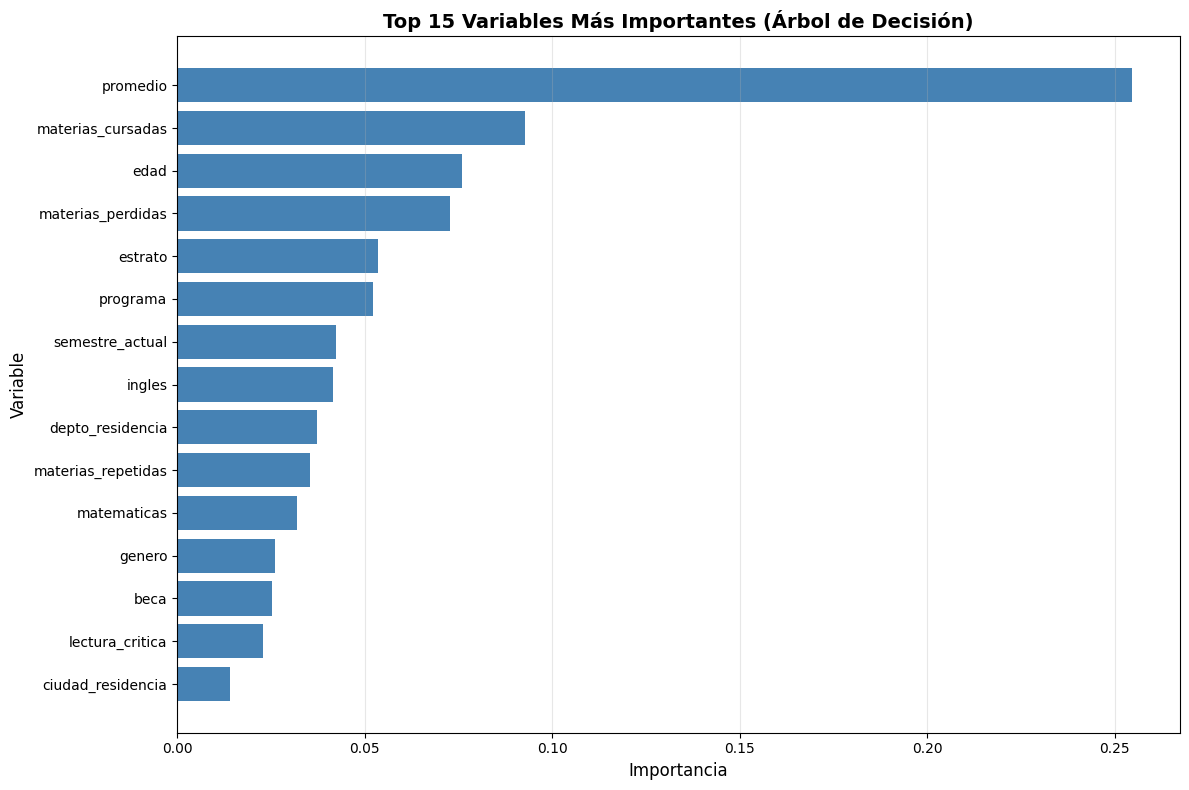


Número de variables que explican el 80% de la importancia: 11
Variables principales (>80%): ['promedio', 'materias_cursadas', 'edad', 'materias_perdidas', 'estrato', 'programa', 'semestre_actual', 'ingles', 'depto_residencia', 'materias_repetidas', 'matematicas']


In [56]:
# Análisis de importancia de variables en el Árbol de Decisión
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nIMPORTANCIA DE VARIABLES - ÁRBOL DE DECISIÓN")
print("Top 20 variables más importantes:")
print(feature_importances.head(20).to_string(index=False))

# Visualización de las top 15 variables
plt.figure(figsize=(12, 8))
top_15 = feature_importances.head(15)
plt.barh(range(len(top_15)), top_15['Importance'].values, color='steelblue')
plt.yticks(range(len(top_15)), top_15['Feature'].values)
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Variable', fontsize=12)
plt.title('Top 15 Variables Más Importantes (Árbol de Decisión)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Calcular porcentaje acumulado
feature_importances['Cumulative'] = feature_importances['Importance'].cumsum()
n_features_80 = (feature_importances['Cumulative'] <= 0.8).sum()
print(f"\nNúmero de variables que explican el 80% de la importancia: {n_features_80}")
print(f"Variables principales (>80%): {list(feature_importances.head(n_features_80)['Feature'].values)}")

## 2. Regresión Logística

In [57]:
# Entrenar Regresión Logística
print("Entrenando Regresión Logística...")

# Crear y entrenar el modelo
lr_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42,
    solver='lbfgs'
)

lr_model.fit(X_train_scaled, y_train)

# Predecir en validación
y_pred_lr_val = lr_model.predict(X_val_scaled)
y_pred_proba_lr_val = lr_model.predict_proba(X_val_scaled)[:, 1]

# Métricas en validación
recall_lr = recall_score(y_val, y_pred_lr_val)
precision_lr = precision_score(y_val, y_pred_lr_val)
f1_lr = f1_score(y_val, y_pred_lr_val)
auc_lr = roc_auc_score(y_val, y_pred_proba_lr_val)

cm_lr = confusion_matrix(y_val, y_pred_lr_val)
tn_lr, fp_lr, fn_lr, tp_lr = cm_lr.ravel()

print("\n--- REGRESIÓN LOGÍSTICA - VALIDACIÓN ---")
print(f"Recall: {recall_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"F1 Score: {f1_lr:.4f}")
print(f"AUC: {auc_lr:.4f}")
print(f"\nMatriz de Confusión:")
print(f"TP: {tp_lr}, FP: {fp_lr}")
print(f"FN: {fn_lr}, TN: {tn_lr}")

# Guardar modelo
with open('modelo_regresion_logistica.pkl', 'wb') as f:
    pickle.dump(lr_model, f)
print("\nModelo guardado como: modelo_regresion_logistica.pkl")

Entrenando Regresión Logística...

--- REGRESIÓN LOGÍSTICA - VALIDACIÓN ---
Recall: 0.7159
Precision: 0.1853
F1 Score: 0.2944
AUC: 0.8282

Matriz de Confusión:
TP: 63, FP: 277
FN: 25, TN: 1053

Modelo guardado como: modelo_regresion_logistica.pkl


## Comparación de Modelos


COMPARACIÓN DE MODELOS EN VALIDACIÓN


,Modelo,Recall,Precision,F1 Score,AUC,TP,FP,TN,FN
0,Red Neuronal (Mejor),1.000000,0.062059,0.116866,0.824154,88,1330,0,0
1,Árbol de Decisión,0.602273,0.184028,0.281915,0.673462,53,235,1095,35
2,Regresión Logística,0.715909,0.185294,0.294393,0.828161,63,277,1053,25


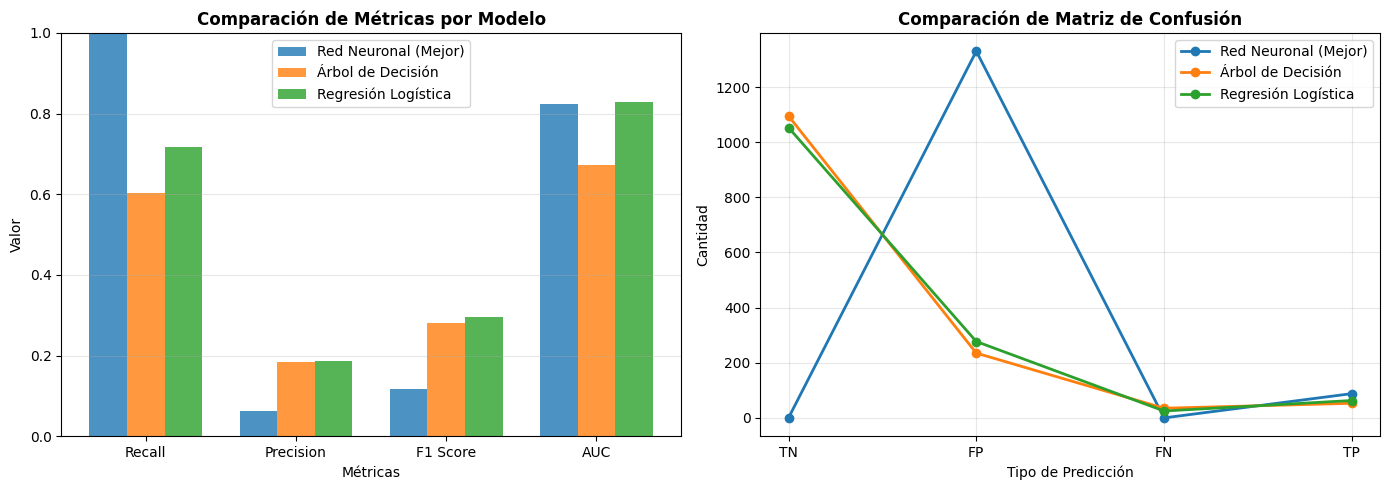


Mejor modelo por Recall: Red Neuronal (Mejor) (1.0000)
Mejor modelo por F1 Score: Regresión Logística (0.2944)


In [58]:
# Comparar todos los modelos
comparacion = pd.DataFrame({
    'Modelo': ['Red Neuronal (Mejor)', 'Árbol de Decisión', 'Regresión Logística'],
    'Recall': [mejor_modelo['recall'], recall_dt, recall_lr],
    'Precision': [mejor_modelo['precision'], precision_dt, precision_lr],
    'F1 Score': [mejor_modelo['f1'], f1_dt, f1_lr],
    'AUC': [mejor_modelo['auc'], auc_dt, auc_lr],
    'TP': [int(mejor_modelo['tp']), tp_dt, tp_lr],
    'FP': [int(mejor_modelo['fp']), fp_dt, fp_lr],
    'TN': [int(mejor_modelo['tn']), tn_dt, tn_lr],
    'FN': [int(mejor_modelo['fn']), fn_dt, fn_lr]
})

print("\nCOMPARACIÓN DE MODELOS EN VALIDACIÓN")
display(comparacion)

# Visualizar comparación
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras para métricas principales
metricas = ['Recall', 'Precision', 'F1 Score', 'AUC']
x = np.arange(len(metricas))
width = 0.25

for i, modelo in enumerate(comparacion['Modelo']):
    valores = comparacion.loc[i, metricas].values
    axes[0].bar(x + i*width, valores, width, label=modelo, alpha=0.8)

axes[0].set_xlabel('Métricas')
axes[0].set_ylabel('Valor')
axes[0].set_title('Comparación de Métricas por Modelo', fontweight='bold')
axes[0].set_xticks(x + width)
axes[0].set_xticklabels(metricas)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])

# Matriz de confusión comparativa
confusion_data = []
for idx, row in comparacion.iterrows():
    confusion_data.append([row['TN'], row['FP'], row['FN'], row['TP']])

labels = ['TN', 'FP', 'FN', 'TP']
x_pos = np.arange(len(labels))

for i, modelo in enumerate(comparacion['Modelo']):
    axes[1].plot(x_pos, confusion_data[i], marker='o', label=modelo, linewidth=2)

axes[1].set_xlabel('Tipo de Predicción')
axes[1].set_ylabel('Cantidad')
axes[1].set_title('Comparación de Matriz de Confusión', fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(labels)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Determinar mejor modelo
mejor_recall_idx = comparacion['Recall'].idxmax()
print(f"\nMejor modelo por Recall: {comparacion.loc[mejor_recall_idx, 'Modelo']} ({comparacion.loc[mejor_recall_idx, 'Recall']:.4f})")

mejor_f1_idx = comparacion['F1 Score'].idxmax()
print(f"Mejor modelo por F1 Score: {comparacion.loc[mejor_f1_idx, 'Modelo']} ({comparacion.loc[mejor_f1_idx, 'F1 Score']:.4f})")